## BI Hausaufgabe 1: Kurts komplizierte Komplikation (kNN)
### Import der Programmbibliotheken und nervige Warnungen ignorieren

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

---
### Aufgabe (a) - Analyse nach CRISP-DM, Eigenschaften und Zusammenhänge der Variablen.
### Sind alle Variablen für die Anwendung eines k-NN Verfahrens notwendig bzw. geeignet? Wenn ja – Warum? Wenn nein – Warum?
---
##### 1. Business Understanding

Kurt hat das Problem, dass er meteorologische Daten der letzten zwei Jahre besitzt sowie die Freizeitaktivität, die er
mit seinen Freunden aufgrund des Wetters gewählt hat.
Ihm fehlt jedoch leider eine Methode zur Klassifikation von neuen Daten. Dadurch könnten neuen Daten direkt einer
Freizeitaktivität zugeordnet werden.
Daher soll im Folgenden ein geeigneter Algorithmus zur Klassifikation gefunden werden.

##### 2. Data Understanding

Im Data Understanding Part widmen wir uns der Datenqualität. Dafür schauen wir uns zunächst die Skalierung an und
stellen fest, dass alle relevanten Daten keinen numerischen Datentyp besitzen. Um die Datenqualität jedoch zu bewerten,
benötigen wir im besten Falle Integers oder Floats - auf jeden Fall numerische Daten.
Um diese zu erhalten, benutzen habe ich zunächst den LabelEncoder genutzt. Hierbei haben die einzelnen Korrelation zwar
Sinn ergeben, die Werte wurden aber sehr seltsam transformiert (z.B. wurde aus [63.56, 18.2, 0.2, 0] -> [3,2,1,0]). Das
ist für die Korrelation gut,

Ein Ausreißer in der Temperatur von -999 wurde durch den Mittelwert ohne diesen Ausreißer von 10 ersetzt. Anschließend
können wir uns ein Diagramm über die fehlenden Werte Anzeigen lassen und stellen fest, dass es keine gibt.
Bei dem LabelEncoder konnte mittels der Korrelationen festgestellt werden, dass die relative
Luftfeuchtigkeit hoch mit Schnee korreliert. Weiterhin fällt die negative Korrelation von Schnee mit der
Temperatur auf. An dieser Stelle könnte man daher überlegen, die Variable Schnee zu entfernen. Da die Korrelation jedoch
nicht übermäßig hoch ist, lassen wir Schnee im DataFrame. Die Korrelationen der einzelnen Variablen mit den
verschiedenen Klassen machen keinen Sinn, weil die Klassen in numerische Werte transformiert wurden, die Daten aber
eigentlich nominal skaliert sind.
Als festgestellt wurde, dass der LabelEncoder seltsam transformiert, wurde der MinMaxScaler verwendet, der die Daten
normalisiert. Danach waren die Daten zwar wie erwartet auf einem Intervall ~ [0,1], jedoch sind die Korrelationen
nicht mehr so schön zu erkennen, aber immernoch vorhanden und erkennbar. Dennoch wurde der MinMaxScaler verwendet.

Idealerweise sollten die fünf Ausprägungen unserer Klasse gleichverteilt sein, da dies eine optimale Klassifikation
bedeuted. In dem Kreisdiagramm sehen wir jedoch, dass diese keineswegs gleichverteilt sind. Demnach tritt Wandern am
Häufigsten und Skifahren am seltesten auf.


##### 3. Data Preparation

Der Bereich Data Preparation widmet sich der vorverarbeitung der Daten, damit diese später adäquat ausgewertet werden
können. In diesem Schritt werden die Daten final so aufbereitet, transformiert und bereinigt, dass sie in den nächsten
Phasen verarbeitet werden können.

Für einen kNN-Algorithmus ist die Variable id irrelevant, da sie keinerlei Aussagekraft für unser im Business
Understanding deklariertes Ziel enthält und lediglich zur Identifikation der einzelnen Messungen dient - was uns nicht
interessiert. Daher kann diese entfernt werden. Zudem macht das Datum für uns nur beschränkt Sinn, weil jede Tag-Monat-
Kombination bei einem Betrachtungszeitraum von zwei Jahren höchstens zweimal vorkommen kann. Zudem wurden die Messungen
nicht täglich durchgeführt, weshalb fast jede Tag-Monat-Kombination nur einmal vorkommt. Theoretisch könnten wir
mithilfe des intervallskalierten Datums jeder Messung eine Jahreszeit zuordnen, was die Datenbasis in vier gleichmäßig
verteilte Ausprägungen des Merkmals unterteilen würde. Der Einfachheit halber löschen wir die Variable Datum jedoch aus
dem Datensatz heraus. Die restlichen Variablen relative Luftfeuchtigkeit, Temperatur, Niederschlag und die Schneehöhe
machen alle Sinn und haben einen Einfluss auf die Klasse.

Da wir festgestellt haben, dass die Ausprägungen der Klasse nicht gleichverteilt ist, könnte es sich lohnen, den
Datensatz zu upsamplen. Das machen wir mit SMOTE aus dem imblearn.over_sampling package. Anschließend sehen wir, dass
die fünf Ausprägungen der Klasse nun gleichverteilt sind.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         105 non-null    int64  
 1   Datum                      105 non-null    object 
 2   relative Luftfeuchtigkeit  105 non-null    float64
 3   Temperatur                 105 non-null    float64
 4   Niederschlag               105 non-null    float64
 5   Schnee                     105 non-null    float64
 6   Freizeitangebot            105 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.9+ KB
None


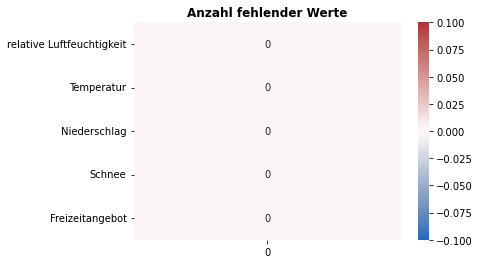

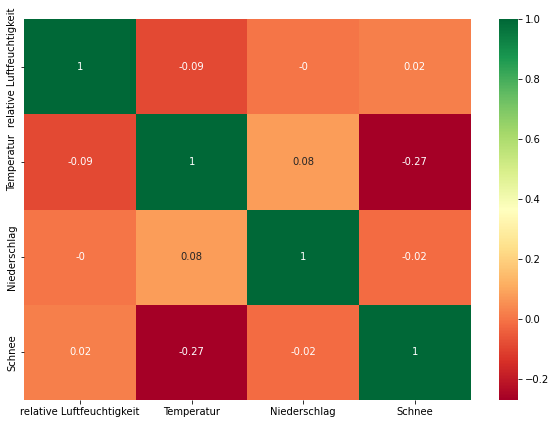

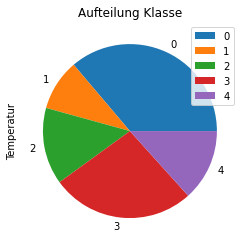

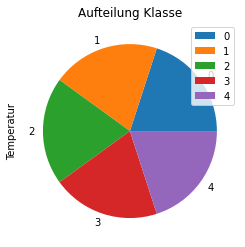

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative Luftfeuchtigkeit  190 non-null    float64
 1   Temperatur                 190 non-null    float64
 2   Niederschlag               190 non-null    float64
 3   Schnee                     190 non-null    float64
 4   Freizeitangebot            190 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 7.5 KB
None


In [117]:
gh_url = "https://raw.githubusercontent.com/ukena/BI/master/%C3%9Cbungsblatt%201%20-%20Daten_Projekt.csv"
df = pd.read_csv(gh_url, sep=";", decimal=",")  # Daten aus der csv als DataFrame Objekt instanziieren
print(df.info())  # Informationen zum DataFrame anzeigen

df = df.drop(["id", "Datum"], axis=1)  # variable id und datum kann vernachlässigt werden

mm = MinMaxScaler()  # MinMaxScaler Objekt instanziieren
col_names = ["relative Luftfeuchtigkeit", "Temperatur", "Niederschlag", "Schnee"]  # zu normalisierende columns setzen
mm_fit_obj = {i: MinMaxScaler().fit(df[[col]]) for i, col in enumerate(col_names)}  # dict mit der Bandbreite der Columns für später
df[col_names] = pd.DataFrame(mm.fit_transform(df[col_names]), columns=col_names)  # columns normalisieren

# Column Freizeitangebot besser manuell in numerische Werte überführen
df["Freizeitangebot"] = df["Freizeitangebot"].map({"Wandern" :0,
                                                   "Skifahren" :1,
                                                   "Lesen" :2,
                                                   "Fussball": 3,
                                                   "Baden": 4}).astype(int)

plt.title("Anzahl fehlender Werte", fontweight="bold")  # Titel für Diagramm festlegen
sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt="d", cmap="vlag")  # Diagramm über fehlende Werte erstellen
plt.show()  # Diagramm anzeigen

corr = df.drop(["Freizeitangebot"], axis=1).corr().round(2)  # Korrelationen aller DataFrame Columns erfassen
plt.figure(figsize=(10, 7))  # Diagrammeingenschaften festlegen
sns.heatmap(corr, annot=True, cmap='RdYlGn')  # Diagramm erstellen
plt.show()  # Diagramm anzeigen

df_agg = df.groupby("Freizeitangebot").count()  # Daten aggregieren
df_agg.plot.pie(title="Aufteilung Klasse", y="Temperatur")  # Diagramm erstellen
plt.show()  # Diagramm anzeigen

upsampler = SMOTE()  # upsamler Objekt instanziieren
X, y = upsampler.fit_resample(df[["relative Luftfeuchtigkeit", "Temperatur", "Niederschlag", "Schnee"]],
                              df["Freizeitangebot"])  # DataFrame resamplen
df = X.assign(Freizeitangebot=y)  # neuen df mit Werten vom resamplen erstellen

# nochmals ein Diagramm erstellen zur Überprüfung
df_agg = df.groupby("Freizeitangebot").count()  # Daten aggregieren
df_agg.plot.pie(title="Aufteilung Klasse", y="Temperatur")  # Diagramm erstellen
plt.show()  # Diagramm anzeigen

print(df.info())  # zum Schluss nochmal eine Info anzeigen

---
### Aufgabe (b) - Unterteilung in 70% Trainings- und 30% Testdaten, mindestens drei verschiedene Werte für k nutzen
### Welchen Einfluss hat k jeweils auf die Güte der Klassifikation? Zeigen Sie dies anhand passender Maße.
### Schlussfolgerung: Warum hat der Parameter k den oben beschriebenen Einfluss? Welches k ist das beste k?
---

Im folgenden werden für k die Werte aus (1, 3, 5, 7, 9) genutzt und anschließend eine Zusammenfassung erstellt.
Welchen Einfluss k hat, wird durch die verschiedenen Kennzahlen ersichtlich. Alle Kennzahlen können in der
Zusammenfassung bei Ausführung des Python Skripts eingesehen werden.
k=1 hat in der Regel die höchste Accuracy (0.8246), für k∈{3, 5, 7, 9} variiert die Accuracy, ist aber marginal niedriger als
bei k=1. Tendenziell kann man sagen, dass die Güte der Klassifikation sinkt, je höher k ist.
Einen Wert von k=1 versucht man eigentlich zu vermeiden, weil das zu Fehlklassifikation bei Ausreißern führen
kann. Da es trotzdem das beste Ergebnis liefert, könnte das bedeuten, dass es wenige Ausreißer gibt und die einzelnen
Klassen sehr nah beeinander liegen. Bei einem größeren k können nämlich Bereiche entstehen, in denen die Anzahl an
nächsten Nachbarn gleich ist. In diesen Bereichen ist dann keine eindeutige Klassifikation möglich.

In [118]:
ks = [1, 3, 5, 7, 9]
x = df.drop(["Freizeitangebot"], axis=1)  # Daten unserer Untersuchungsvariable als x festlegen
y = df["Freizeitangebot"]  # alle anderen Daten als y festlegen

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21)  # aufteilen der Daten

for k in ks:  # über ide fünf verschiedenen Werte für k iterieren
    knn = KNeighborsClassifier(n_neighbors=k)  # kNN als Classifier Objekt mit k Nachbarn
    knn.fit(x_train, y_train)  # Trainingsdaten fitten
    print("\n" + "=" * 20 + f"kNN mit {k} Nachbarn" + "=" * 20)  # coole Zeile anzeigen
    y_pred = knn.predict(x_test)

    arg_test = {"y_true": y_test, "y_pred": y_pred}  # Variablen als dict erstellen zum späteren entpacken als parameter
    confusion = confusion_matrix(**arg_test)  # confusion matrix erstellen
    print(confusion)  # confusion matrix anzeigen
    classification = classification_report(**arg_test)  # classification report erstellen
    print(classification)  # classification report anzeigen

    print(f"Accuracy für k={k}: ", accuracy_score(y_test, knn.predict(x_test)).round(4))



====================kNN mit 1 Nachbarn====================
[[10  0  0  0  0]
 [ 0  9  0  0  0]
 [ 1  0 15  0  0]
 [ 0  0  1  6  2]
 [ 0  0  0  1 12]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00         9
           2       0.94      0.94      0.94        16
           3       0.86      0.67      0.75         9
           4       0.86      0.92      0.89        13

    accuracy                           0.91        57
   macro avg       0.91      0.91      0.91        57
weighted avg       0.91      0.91      0.91        57

Accuracy für k=1:  0.9123

====================kNN mit 3 Nachbarn====================
[[ 9  0  0  1  0]
 [ 0  9  0  0  0]
 [ 2  0 14  0  0]
 [ 0  0  1  6  2]
 [ 0  0  0  1 12]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      1.00      1.00         9
           2       0

---
### Aufgabe (c) besten Wert für k auswählen, Güte der Klassifikation verbessern:
###   • 10-fache Kreuzvalidierung
###   • Abstands-gewichtetes KNN
### Wie hat sich die Klassifikationsgüte jeweils geändert? Beschreiben Sie die Änderungen. Finden Sie Erklärungen dafür?
---

Mittels 10-facher Kreuzvalidierung und Abstands-gewichtetes KNN (mittels weights="distance" parameter) ist es gelungen,
die Klassifikation zu verbessern: vorher hatte k=1 eine accuracy von 0.8246, nun hat die accuracy einen Mittelwert von
0.8789. Dabei fällt auf, dass die Kreuzvalidierung nicht so einen großen Einfluss hat, wie die "Belohnung" für einen
geringen Abstand. Das bestärkt die bereits aufgestellte Vermutung, dass die einzelnen Klassen sehr nah beeinander
liegen.

In [119]:
x = df.drop(["Freizeitangebot"], axis=1)  # Daten unserer Untersuchungsvariable als x festlegen
y = df["Freizeitangebot"]  # alle anderen Daten als y festlegen

knn_cv = KNeighborsClassifier(n_neighbors=1, weights="distance")  # kNN als Classifier Objekt mit k Nachbarn
knn_cv.fit(x, y)  # Trainingsdaten fitten
cv_scores = cross_val_score(knn_cv, x, y, cv=10, scoring="accuracy")  # 10-fache Kreuzvalidierung

print(cv_scores)  # jeden cv-wert anzeigen
print(f"cv_scores mean:{np.mean(cv_scores)}")  # cv-werte mitteln

[0.84210526 0.78947368 0.94736842 0.78947368 0.84210526 1.
 0.94736842 1.         0.73684211 1.        ]
cv_scores mean:0.8894736842105262


---
### Aufgabe (d) Eigene Testdaten mit bestem Wert für k und zwei Distanzmaße.
### Welchen Beschäftigungen sollten Kurt und seine Freunde an den folgenden beiden Tagen nachgehen?
### Verwenden Sie ihre vorverarbeiteten Daten mit dem ermittelten besten Wert für k.
### Ermitteln Sie die Lösungen für 2 verschiedene Distanzmaße.
---

Die Werte müssen selbstverständlich ebenfalls normalisiert werden, ansonsten würden sie viel zu groß sein und damit
falsch klassifiziert werden. Dabei kann, wie sich nach vielem testen herausgestellt hat, leider nicht einfach die
fit_transform Methode der MinMaxScaler Klasse verwendet werden, weil sonst die Bandbreite der Daten kleiner wäre. Daher
müssen die jeweiligen MinMaxScaler Objekte verwendet werden, die für jede Column auf die gesamte Bandbreite gefittet
wurden. Diese auf die Bandbreite angepassten Objekte wurden im Teil Data Preparation in einem dict als value mit dem
jeweiligen Index der Column als key gespeichert. Dadurch kann auf die Objekte (und damit die gesamte Bandbreite)
zugegriffen werden und die neuen Daten können adäquat normalisiert werden.

Bei der Vorhersage kommen bei beiden kNN Classifiern (mit und ohne Kreuzvalidierung und Abstandsgewichtung) sowie bei
den beiden verschieden Metriken zur Distanzberechnung (Manhattan und Euklid) das Selbe Ergebnis:
die Datenreihe [63.56, 18.2, 0.2, 0] wird der Klasse 3, also Fußball zugeordnet und die Datenreihe
[71.90, 23.1, 0, 0] wird als Baden klassifiziert. Diese Klassifikation macht augenscheinlich durchaus Sinn.

In [120]:
test_1 = np.array([63.56, 18.2, 0.2, 0])
test_2 = np.array([71.90, 23.1, 0, 0])

for ind, test in enumerate((test_1, test_2)):
    for i, fit in mm_fit_obj.items():
        test[i] = fit.transform([[test[i]]])

    knn_euklid = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    knn_manhattan = KNeighborsClassifier(n_neighbors=1, metric="manhattan")

    knn_euklid.fit(x, y)  # Trainingsdaten fitten
    knn_manhattan.fit(x, y)  # Trainingsdaten fitten

    pred_euklid = knn_euklid.predict([test])
    pred_manhattan = knn_manhattan.predict([test])

    print(f"{ind+1}. Datenreihe mit euklidischer Distanz klassifiziert als Klasse {pred_euklid}")
    print(f"{ind+1}. Datenreihe mit manhattan Distanz klassifiziert als Klasse {pred_manhattan}")


ValueError: Found input variables with inconsistent numbers of samples: [190, 1]